In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from copy import deepcopy
import tkinter as tk

tau = 1
gamma = 1.8

#Note regarder le break de delaunay

class blob:
    def __init__(self,N,nPuits,nSources,sourcemod="1",maille="square"):
        self.sources = []
        tab_choix = [i for i in range(N-1)]
        for i in range(nSources):
            choix = np.random.choice(tab_choix)
            self.sources.append(choix)
            tab_choix.remove(choix)
        self.non_source = tab_choix.copy()
        self.puits = []
        tab_choix2 = [i for i in range(N-1)]
        for i in range(nPuits):
            choix = np.random.choice(tab_choix)
            self.puits.append(choix)
            tab_choix.remove(choix)
            tab_choix2.remove(choix)
        self.non_puit = tab_choix2.copy()
        self.X = int(np.around(np.power(N, 1/3)))
        self.Y = int(np.around(np.power(N, 1/3)))
        self.Z = int(np.around(np.power(N, 1/3)))
        self.N = N
        self.noeuds = []
        self.triangles = []
        #Initialisation des noeuds
        if maille == "square":
            for n in range(N): 
                self.noeuds.append(noeud(n,self.X,self.Y))
        elif maille == "hex":
            for n in range(N):
                self.noeuds.append(hexnoeud(n,self.X,self.Y))
        elif maille == "Delaunay":
            for n in range(N):
                self.noeuds.append(Delaunoeud(n,self.X,self.Y,self))
            self.jarvis = self.jarvis_march()
            self.tri_polygon(self.jarvis)
            for knot in self.noeuds:
                knot.addtogrid(self)
            self.plot_noeuds()
            self.delaunay()
            for triangle in self.triangles:
                for un_noeud in triangle:
                    un_noeud.add_voisins(triangle)
            for un_noeud in self.noeuds:
                un_noeud.get_D()
        elif maille == "3D":
            for n in range(N):
                self.noeuds.append(noeud3D(n,self.X,self.Y,self.Z))
        #Attribution des parametres des noeuds
        for un_noeud in self.noeuds:
            un_noeud.get_L(self)
        #Définition des valeurs initiales de I pour les puits et les sources
        if sourcemod == "1":
            self.Itot = -nSources
            for puit in self.puits :
                self.get_noeud(puit).I = 4
            for source in self.sources :
                self.get_noeud(source).I = -4
        if sourcemod == "random":
            Itot = 0
            for source in self.sources :
                rand = np.random.lognormal(0,1)
                self.get_noeud(source).I = -rand
                Itot -= rand
            self.Itot = Itot
            for puit in self.puits[:-1] :
                rand = abs(Itot)
                while (rand >= abs(Itot)) :
                    rand = np.random.lognormal(0,1)
                self.get_noeud(puit).I = rand
                Itot += rand
            self.get_noeud(self.puits[-1]).I = -Itot
        if sourcemod == "choice" :
            S = 0
            P = 0
            for i,source in enumerate(self.sources) :
                self.get_noeud(source).I = int(input("Intensité de la source n°{}".format(i+1)))
                S += self.get_noeud(source).I
            for i,puit in enumerate(self.puits[:-1]) :
                self.get_noeud(puit).I = int(input("Intensité du puit n°{}".format(i+1)))
                P += self.get_noeud(puit).I
            self.puits[-1] = -P - S


    def plot_noeuds(self):
        fig = plt.figure()
        self.plot_jarvis()
        #self.plot_branch()
        for tri in self.triangles:
            self.plot_polygon(tri)
        for noeud in self.noeuds:
            plt.text(noeud.x,noeud.y,str(noeud.index),color='black',backgroundcolor='white',fontsize=8)
        plt.show()

    def plot_branch(self):
        for noeud in self.noeuds:
            for k,j in enumerate(noeud.voisins):
                knot = self.get_noeud(j)
                plt.plot([noeud.x,knot.x],[noeud.y,knot.y],linewidth= noeud.D[k]*5,color = 'r')

    def plot_puit(self):
        fig = plt.figure()
        for i in self.puits:
            puits = self.get_noeud(i)
            plt.scatter(puits.x,puits.y,color='g')
        plt.show()
    def plot_sources(self):
        fig = plt.figure()
        for j in self.sources:
            sources = self.get_noeud(j)
            plt.scatter(sources.x,sources.y,color='b')
        plt.show()

    def plot(self):
        fig = plt.figure()
        for noeud in self.noeuds:
            for k,j in enumerate(noeud.voisins):
                knot = self.get_noeud(j)
                plt.plot([noeud.x,knot.x],[noeud.y,knot.y],linewidth = (noeud.D[k])*5,color = 'r',zorder=0.5)
        for i in self.puits:
            puits = self.get_noeud(i)
            plt.scatter(puits.x,puits.y,color='g')
        for i in self.sources:
            sources = self.get_noeud(i)
            plt.scatter(sources.x,sources.y,color='b')
        if (self.sources != []):
            plt.scatter(sources.x,sources.y, color='b', label='Sources')
        if (self.puits != []):
            plt.scatter(puits.x,puits.y, color='g', label='Puits')
        if (self.sources != [] and self.puits != []):
            plt.legend(fontsize = 'small', loc = 'upper right')
            plt.show()
    
    def plot_noeud3D(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for noeud in self.noeuds:
            ax.scatter(noeud.x, noeud.y, noeud.z, marker ="h",color = 'r')
        plt.show()
        
    def plot3D(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for noeud in self.noeuds:
            for k,j in enumerate(noeud.voisins):
                knot = self.get_noeud(j)
                ax.plot([noeud.x,knot.x],[noeud.y,knot.y],[noeud.z,knot.z],linewidth = (noeud.D[k])*5,color = "r",zorder=0.5)
        for i in self.puits:
            puits = self.get_noeud(i)
            ax.scatter(puits.x,puits.y,puits.z, color="g")
        for i in self.sources:
            sources = self.get_noeud(i)
            ax.scatter(sources.x,sources.y,sources.z,color="b")
        plt.show()

    def get_noeud(self,n):
        return self.noeuds[n]

    def calcule_A(self):
        A = np.zeros((self.N,self.N))
        for i,noeud in enumerate(self.noeuds):
            aii=0
            for k,j in enumerate(noeud.voisins):
                A[i,j] = noeud.D[k]/noeud.L[k]
                aii -= noeud.D[k]/noeud.L[k]
            A[i,i] = aii
        return A

    def get_I(self):
        self.I = []
        for noeud in self.noeuds:
            self.I.append(noeud.I)
        return np.array(self.I)

    def calcule_p(self):
        A = self.calcule_A()
        I = self.get_I()
        P = np.linalg.lstsq(A,I,rcond=None)[0]
        for i,noeud in enumerate(self.noeuds):
            noeud.P = P[i]

    def calcule_D(self,dt,TAU=tau,GAMMA=gamma,puits=False,sources=False): #SPfixe = True
        if puits:
            nPuits = len(self.puits)
            for i in self.puits:
                self.get_noeud(i).I = 0
            self.puits = []
            tab_choix = self.non_source.copy()
            for i in range(nPuits):
                choix = np.random.choice(tab_choix)
                self.puits.append(choix)
                tab_choix.remove(choix)
            for i in self.puits:
                self.get_noeud(i).I = -(self.Itot)/nPuits

        if sources:
            nSources = len(self.sources)
            for i in self.sources:
                self.get_noeud(i).I = 0
            self.sources = []
            tab_choix = self.non_puit.copy()
            for i in range(nSources):
                choix = np.random.choice(tab_choix)
                self.sources.append(choix)
                tab_choix.remove(choix)
            for i in self.sources:
                self.get_noeud(i).I = (self.Itot)/nSources

        self.calcule_p()
        for noeud in self.noeuds:
            for j,voisin in enumerate(noeud.voisins):
                knot = self.get_noeud(voisin)
                noeud.D[j] = noeud.D[j] + equa_diff(noeud,knot,j,TAU,GAMMA)*dt

    def jarvis_march(self):
        p0 = self.noeuds[0]
        jarvis = []
        for noeud in self.noeuds:
            if noeud.x < p0.x:
                p0 = noeud
        jarvis.append(p0)
        angle_min = -3.2
        for p in self.noeuds:
            if p != jarvis[0]:
                if jarvis[0].angle(jarvis[0],p)>angle_min:
                    p0 = p
                    angle_min = jarvis[0].angle(jarvis[0],p)
        jarvis.append(p0)
        while(p0 != jarvis[0]):
            angle_min = -3.2
            for p in self.noeuds:
                if p != jarvis[-1]:
                    if jarvis[-1].angle(jarvis[-2],p)>angle_min:
                        p0 = p
                        angle_min = jarvis[-1].angle(jarvis[-2],p)
            jarvis.append(p0)
        return jarvis

    def plot_jarvis(self):
        for i,noeud in enumerate(self.jarvis):
            knot = self.jarvis[(i+1)%len(self.jarvis)]
            plt.plot([noeud.x,knot.x],[noeud.y,knot.y],linewidth= 5,color = 'r')

    def plot_polygon(self,polygon):
        for i,noeud in enumerate(polygon):
            knot = polygon[(i+1)%len(polygon)]
            plt.plot([noeud.x,knot.x],[noeud.y,knot.y],linewidth= 2,color = 'b')

    def tri_polygon(self,polygon):
        for i in range(len(polygon)-2):
            if polygon[i+2] == polygon[0]:
                break
            self.triangles.append([polygon[0],polygon[i+1],polygon[i+2]])

    def delaunay(self):
        c = 0
        i=-1
        while(i!=0):
            i=0
            for triangle in self.triangles:
                for tri in self.triangles :
                    if tri != triangle and is_quad(triangle,tri):
                        if swap(triangle,tri,self):
                            i += 1
                            c += 1
                            #self.plot_noeuds()
                            break
        print(c)

In [2]:
def equa_diff(noeud,knot,j,tau=tau,gamma=gamma) :
    D = noeud.D[j]
    L = noeud.L[j]
    pi = noeud.P
    pj = knot.P
    Q = abs((D/L)*(pj-pi))
    return (Q**gamma)/(1+(Q**gamma)) - D/tau


In [3]:
class noeud:
    def __init__(self, n, X, Y, k=0.5):
        self.index = n
        self.x = n % X + (np.random.rand() - 0.5) * k
        self.y = (n - (n) % X) / Y + (np.random.rand() - 0.5) * k
        self.I = 0
        self.P = 0
        self.voisins = []
        self.create_voisins(n, X, Y)
        self.get_D()

    def create_voisins(self, n, X, Y):
        if (n - (n) % X) / Y != 0:
            self.voisins.append(n - Y)
        if n % X != 0:
            self.voisins.append(n - 1)
        if n % X != X - 1:
            self.voisins.append(n + 1)
        if (n - (n) % X) / Y != Y - 1:
            self.voisins.append(n + Y)

    def get_L(self, blob):
        self.L = []
        for j in self.voisins:
            autre_noeud = blob.get_noeud(j)
            self.L.append(self.dist(autre_noeud))

    def get_D(self):
        self.D = []
        for j in self.voisins:
            self.D.append(1.0)

    def dist(self,autre_noeud):
        x1 = self.x
        y1 = self.y
        x2 = autre_noeud.x
        y2 = autre_noeud.y
        return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [4]:
class noeud3D(noeud):
    def __init__(self, n, X, Y, Z, k=0.25):
        self.index = n
        self.x = n % X + (np.random.rand() - 0.5) * k
        self.y = (n % (X*Y)) // X + (np.random.rand() - 0.5) * k
        self.z = n//(X*Y) + (np.random.rand() - 0.5) * k
        self.I = 0
        self.P = 0
        self.voisins = []
        self.create_voisins(n, X, Y, Z)
        self.get_D()
    def create_voisins(self, n, X, Y, Z):
        if ((n + 1)%X != 0): #A droite
            self.voisins.append(n + 1)
            #print(self.voisins, "droite")
        if (n % X != 0): #A gauche
            self.voisins.append(n - 1)
            #print(self.voisins, "gauche")
        if ((X*Y - n%(X*Y)) > Y): #Devant
            self.voisins.append(n + Y)
            #print(self.voisins, "derriere")
        if (X*Y - n%(X*Y) < (X-1)*Y) : #Derriere
            self.voisins.append(n - Y)
            #print(self.voisins, "devant")
        if (n >= X*Y):         #En dessous
            self.voisins.append(n - X*Y)
            #print(self.voisins, "dessous")
        if (n < X*Y*Z - X*Y):  #Au dessus
            self.voisins.append(n + X*Y)
            #print(self.voisins, "dessus")
        for i in self.voisins:
            if i >= X*Y*Z or i < 0:
                print("Erreur avec", n, "un voisin vaut", i)
            
    def dist(self,autre_noeud):
        x1 = self.x
        y1 = self.y
        z1 = self.z
        x2 = autre_noeud.x
        y2 = autre_noeud.y
        z2 = autre_noeud.z
        return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)

In [5]:
test_noeud = noeud3D(24,3,3,3)
print(test_noeud.x)
print(test_noeud.y)
print(test_noeud.z)
test_noeud.voisins

0.07413483010811159
2.091267769844232
1.988487506469881


[25, 21, 15]

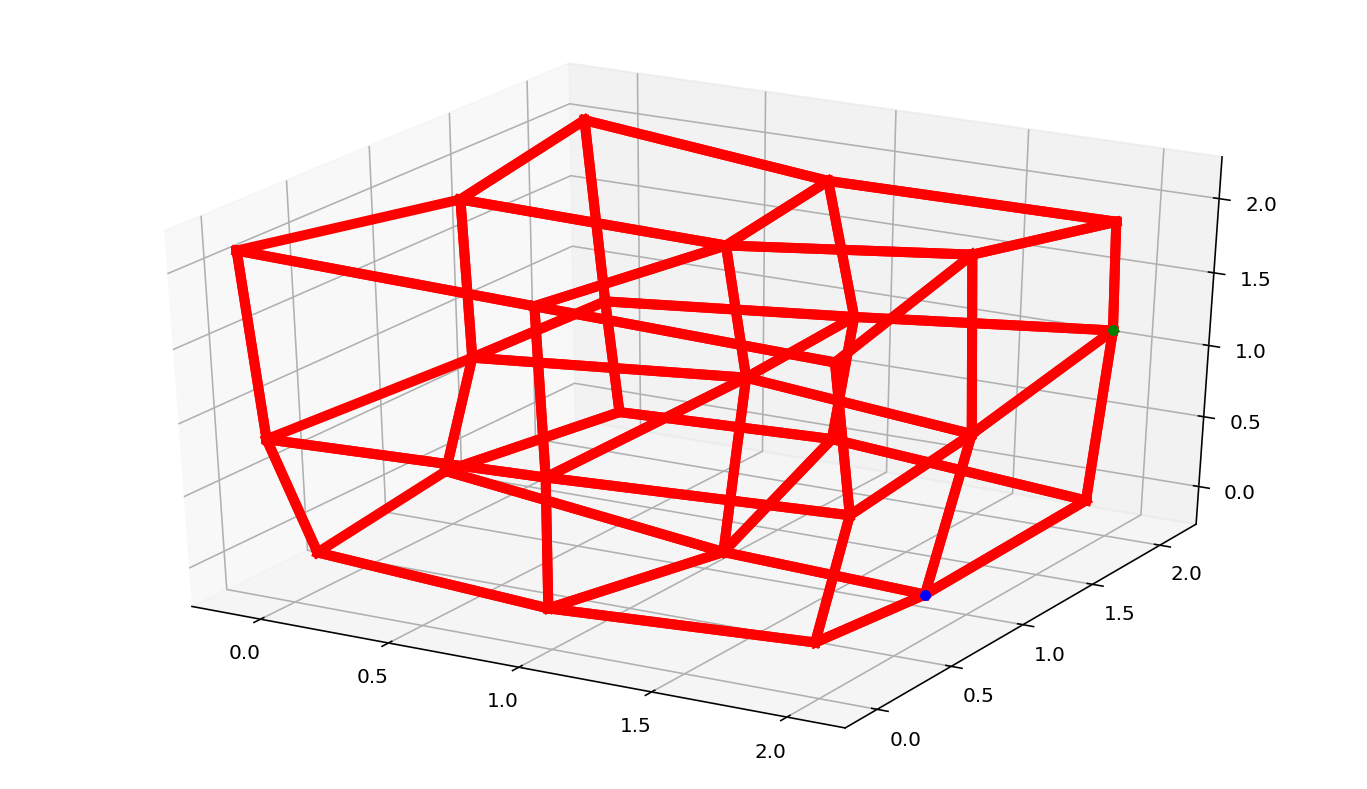

In [6]:
test_blob = blob(27,1,1,maille="3D")
test_blob.plot3D()

Le temps de la figure en dessous est t = 0


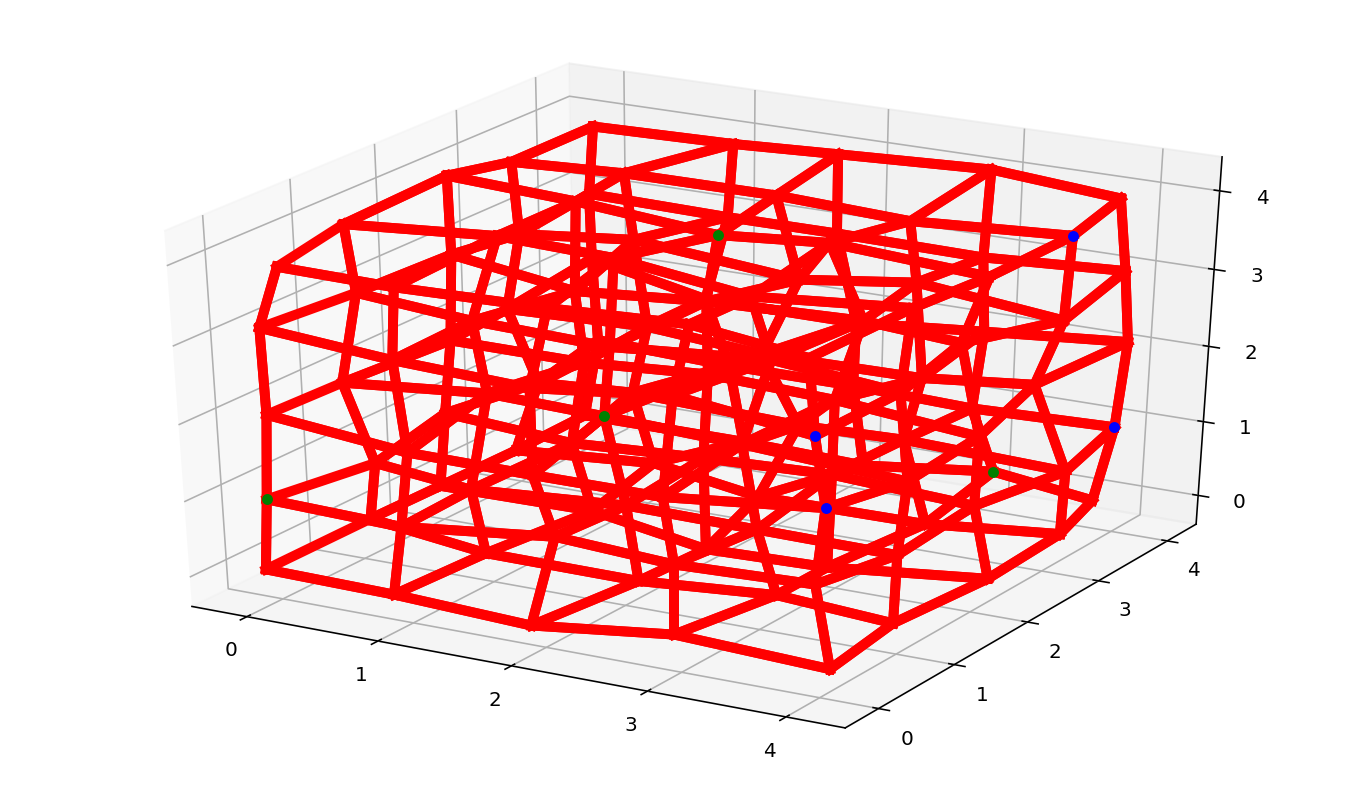

Le temps de la figure en dessous est t = 100


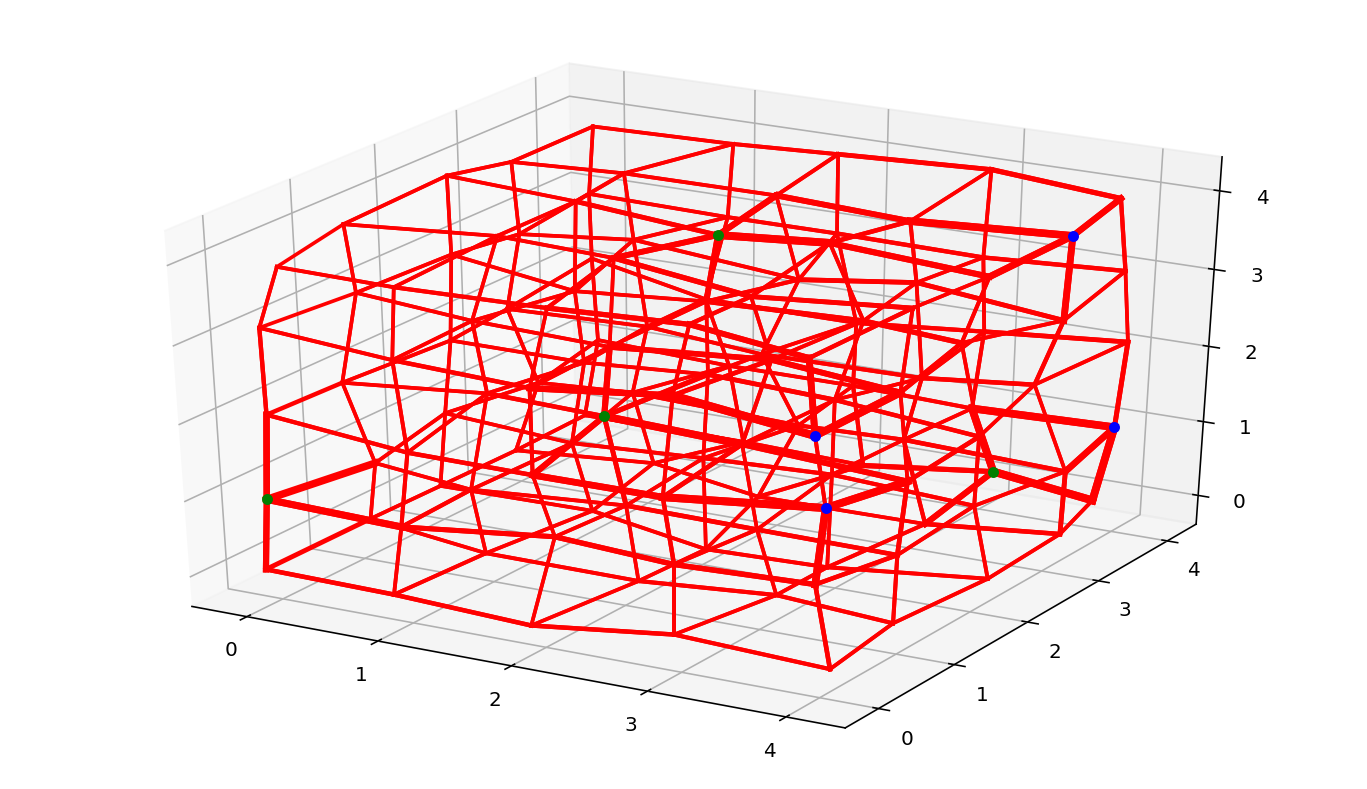

Le temps de la figure en dessous est t = 200


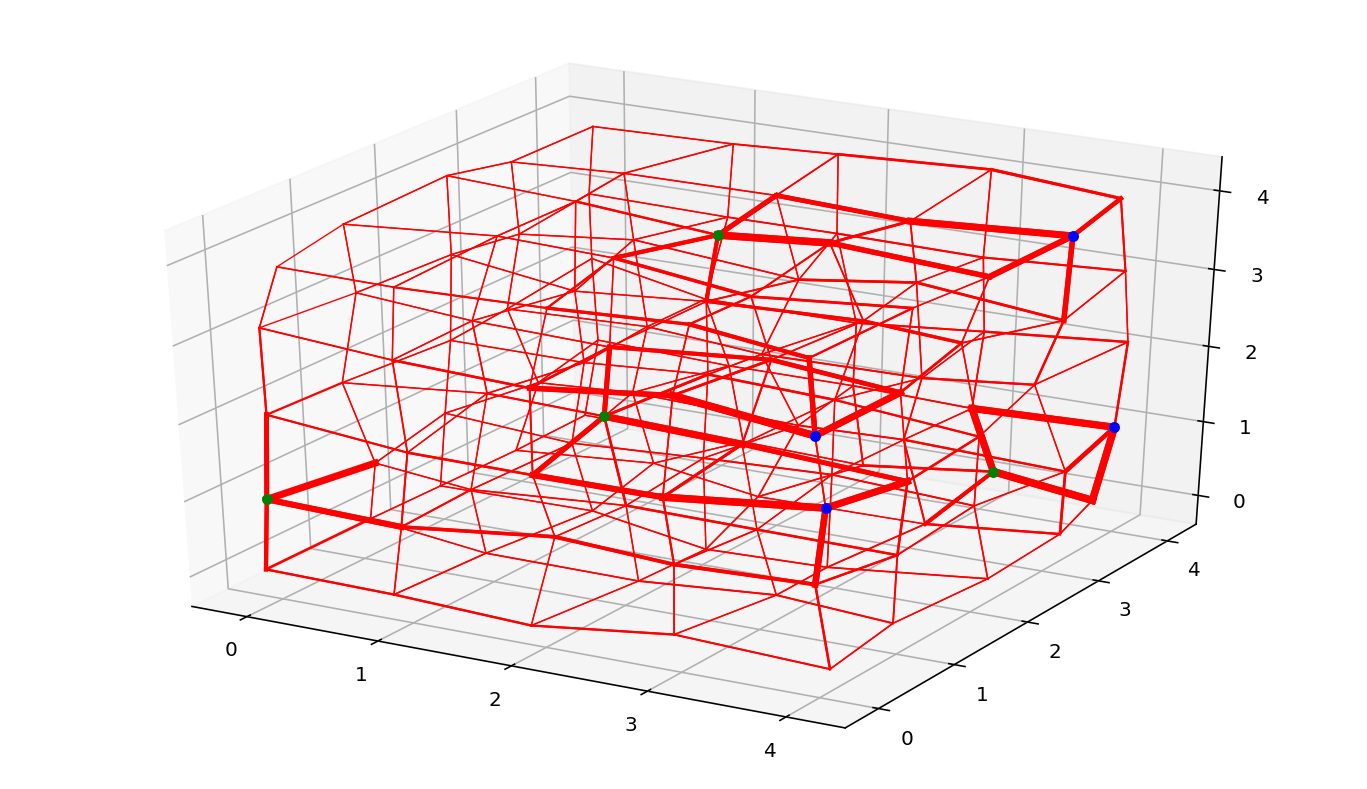

Le temps de la figure en dessous est t = 300


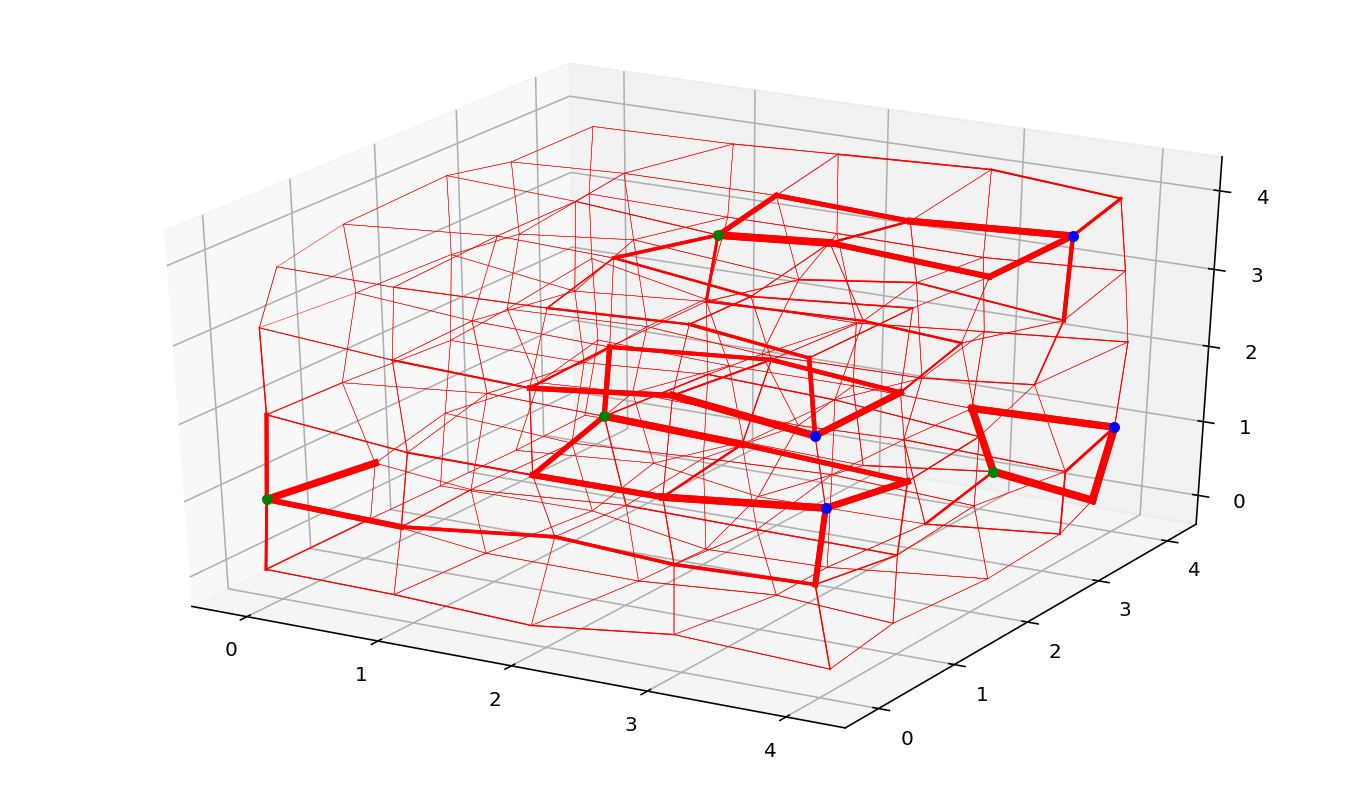

Le temps de la figure en dessous est t = 400


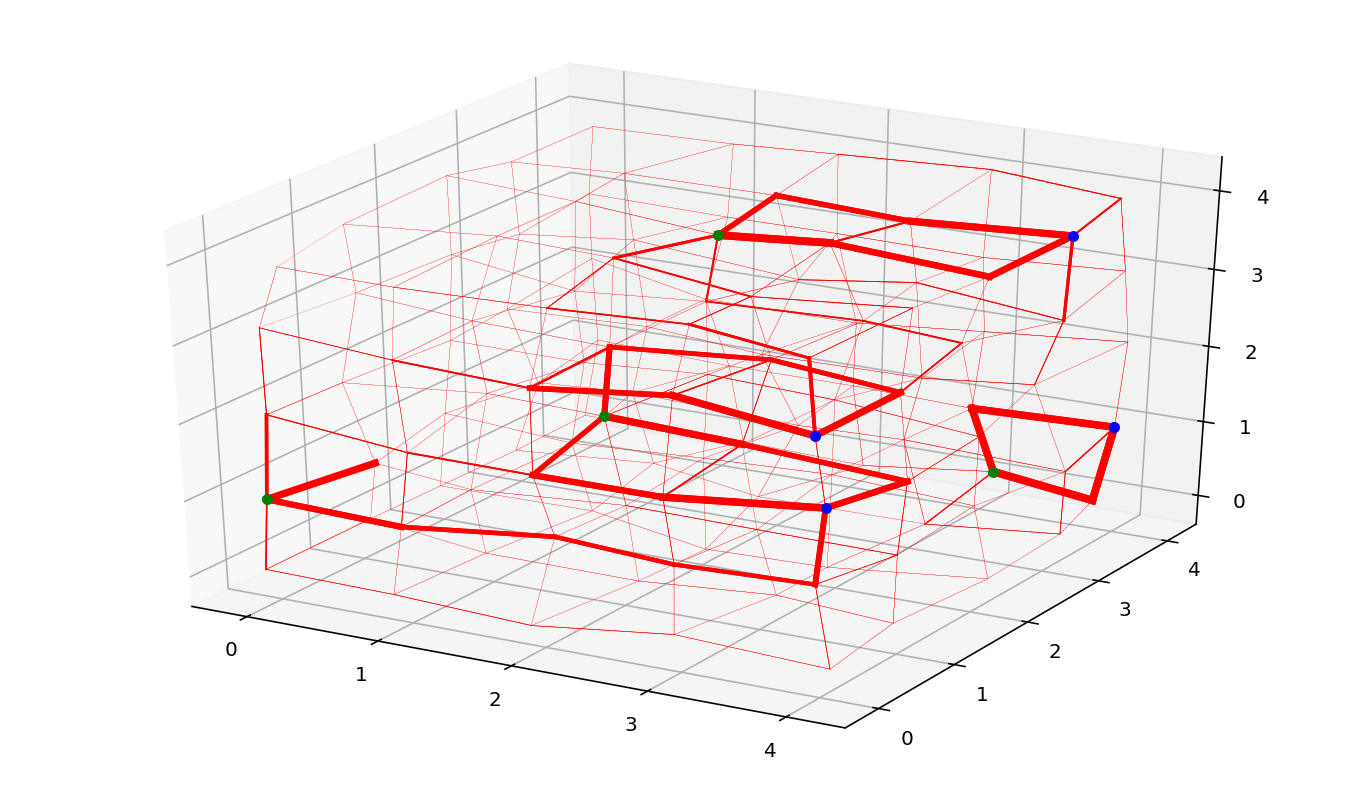

Le temps de la figure en dessous est t = 500


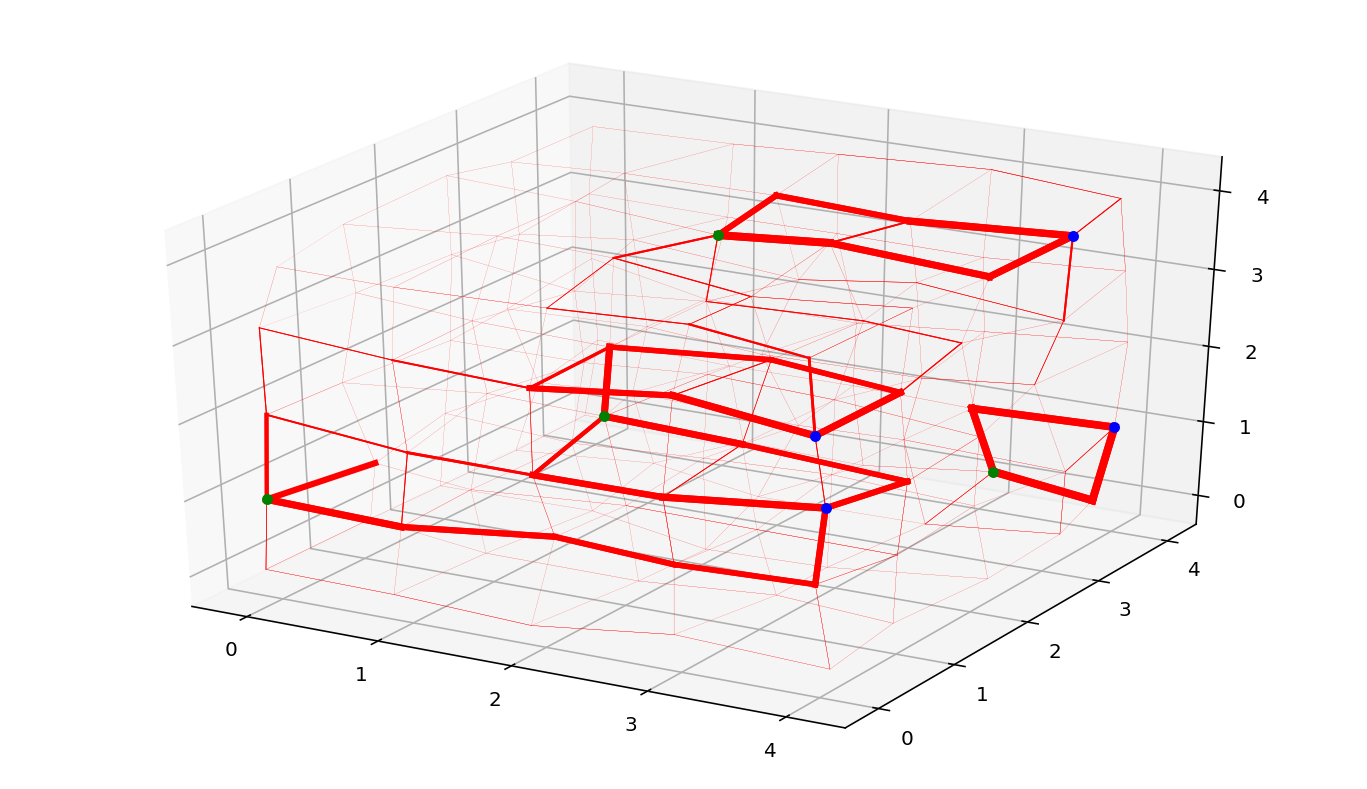

Le temps de la figure en dessous est t = 600


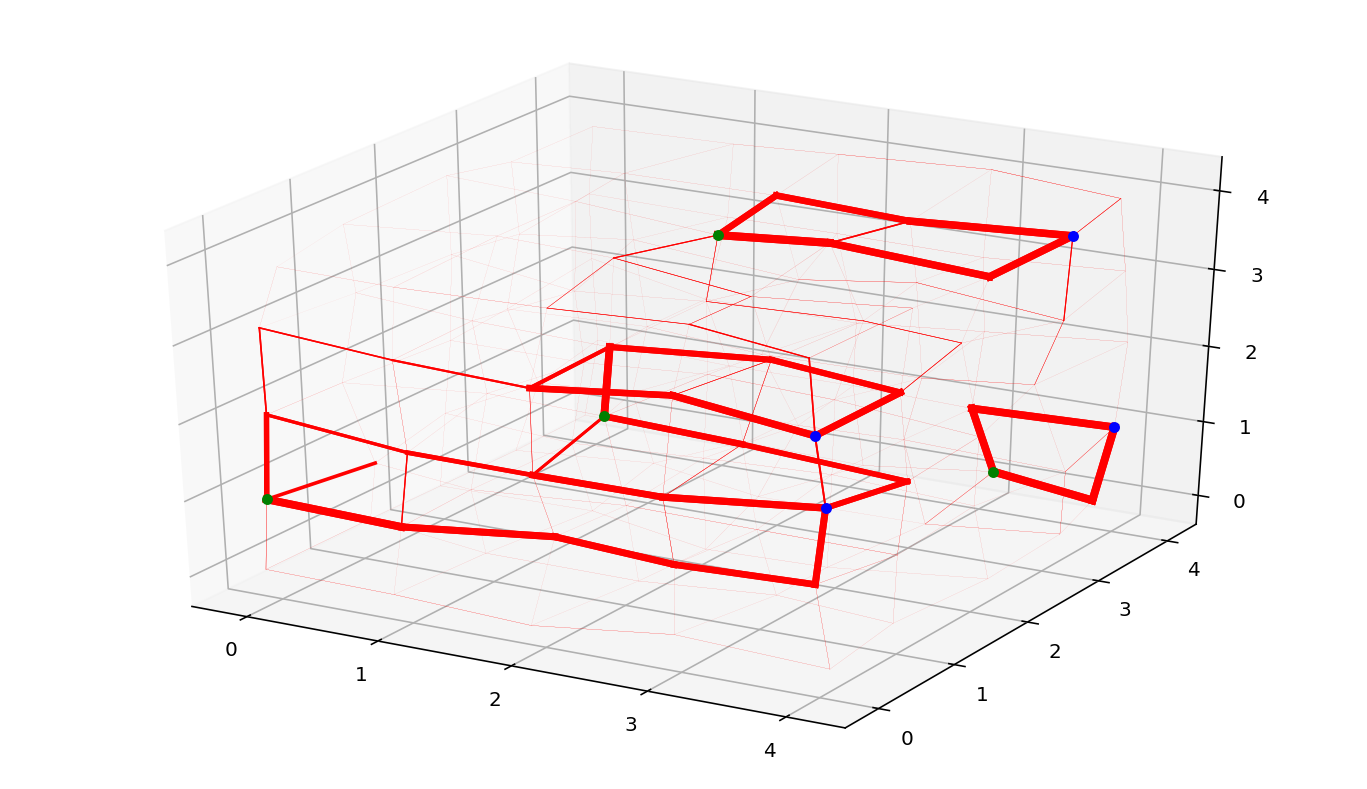

Le temps de la figure en dessous est t = 700


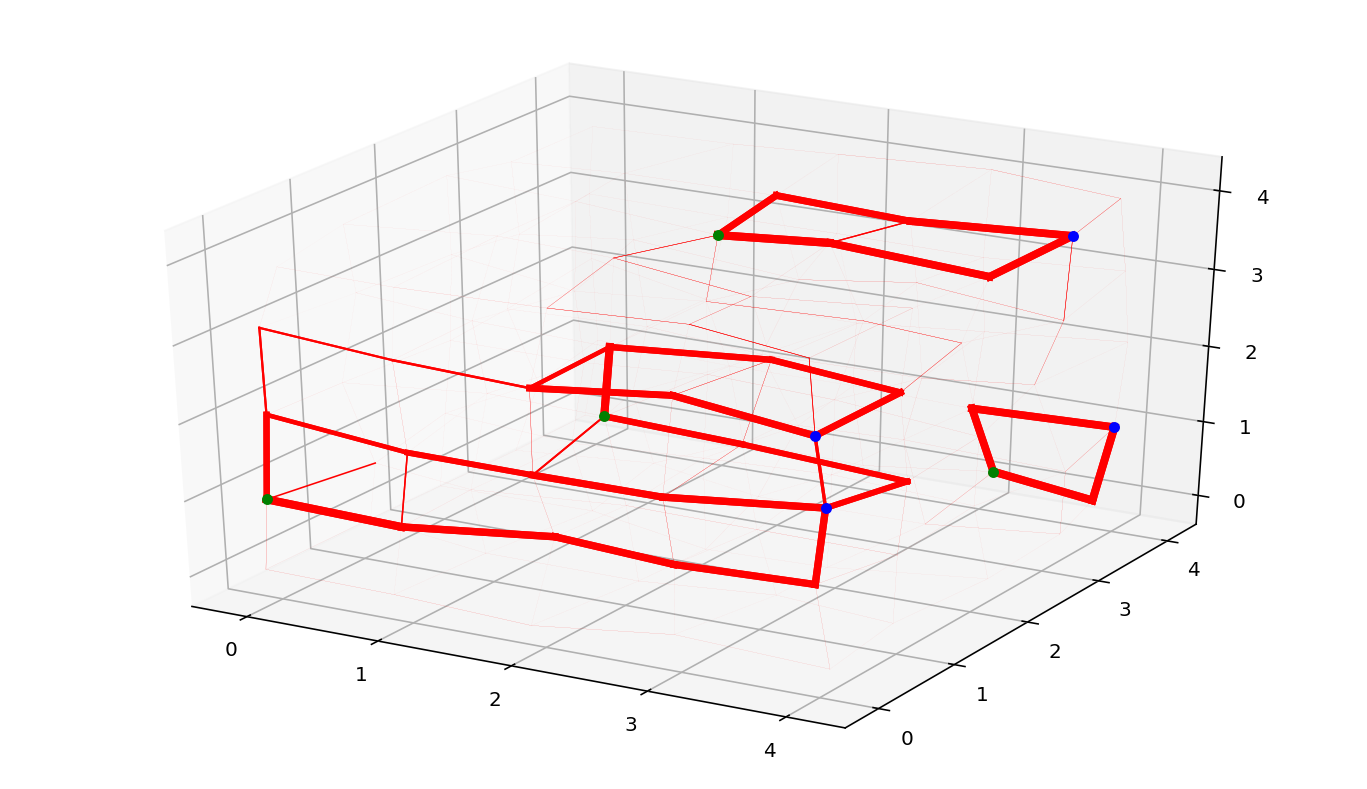

Le temps de la figure en dessous est t = 800


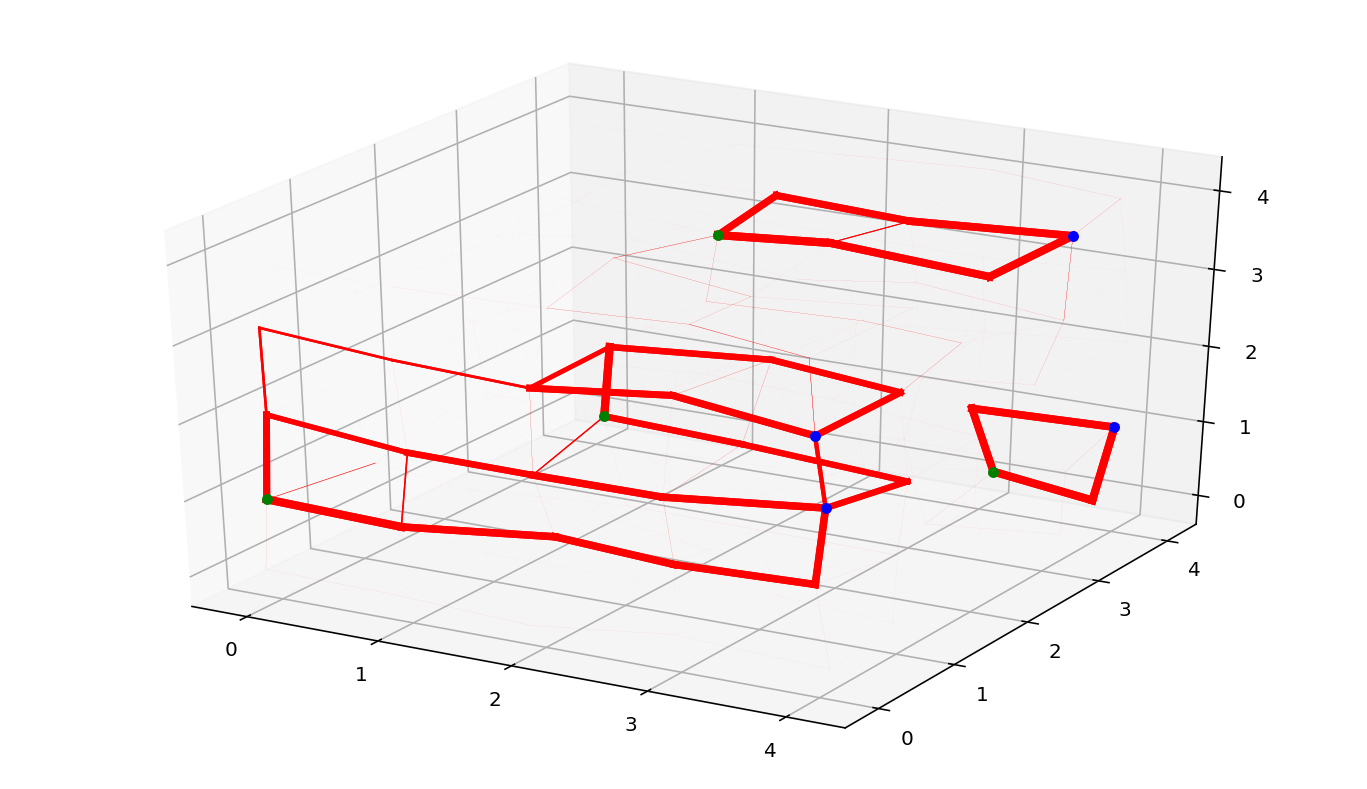

Le temps de la figure en dessous est t = 900


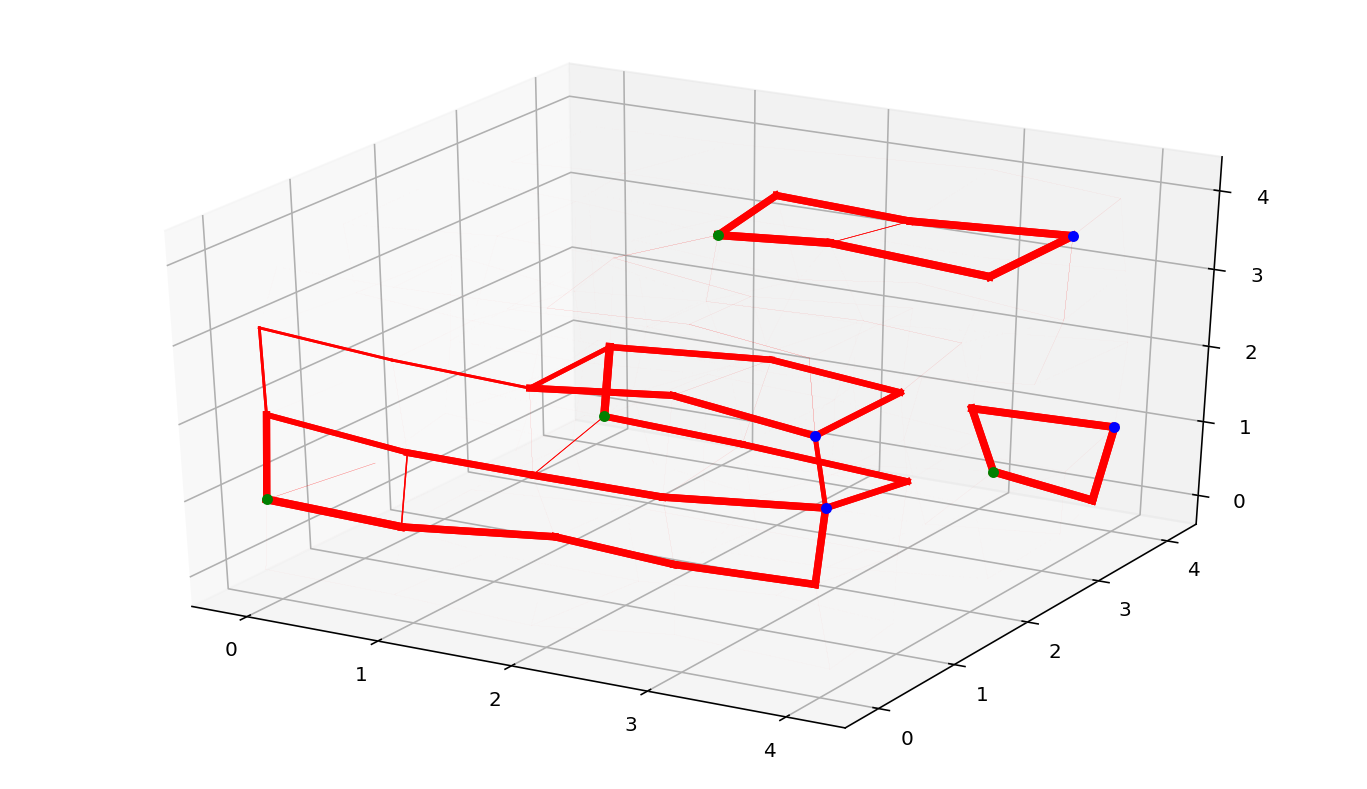

Le temps de la figure en dessous est t = 1000


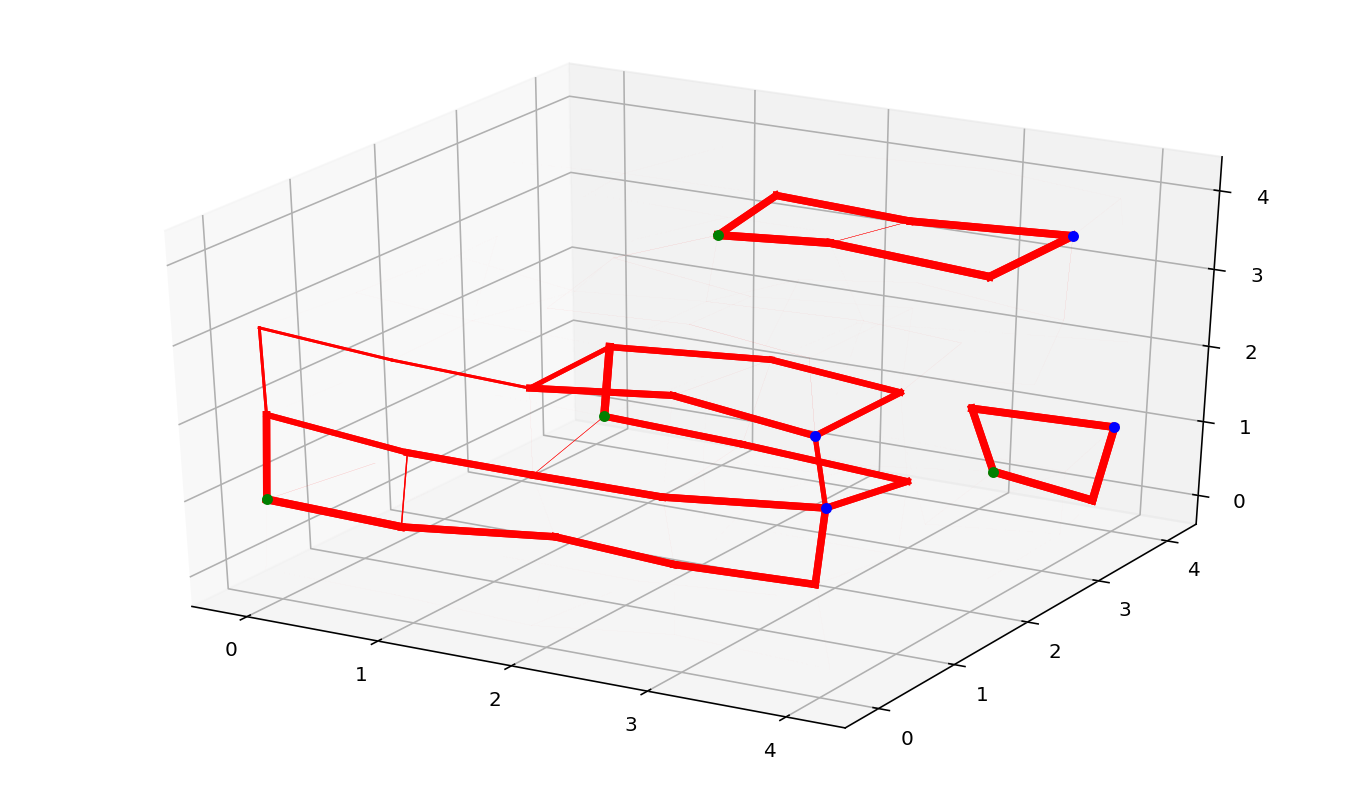

Le temps de la figure en dessous est t = 1100


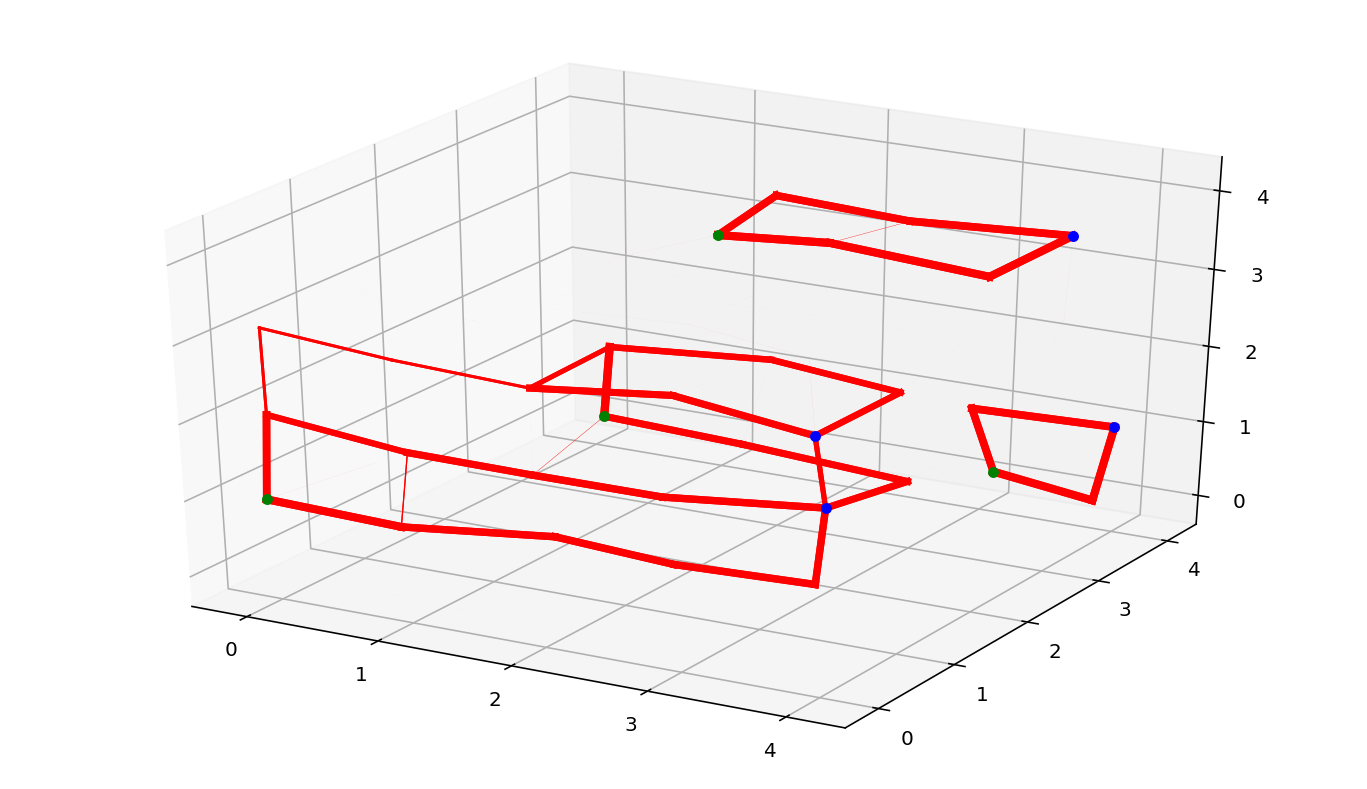

Le temps de la figure en dessous est t = 1200


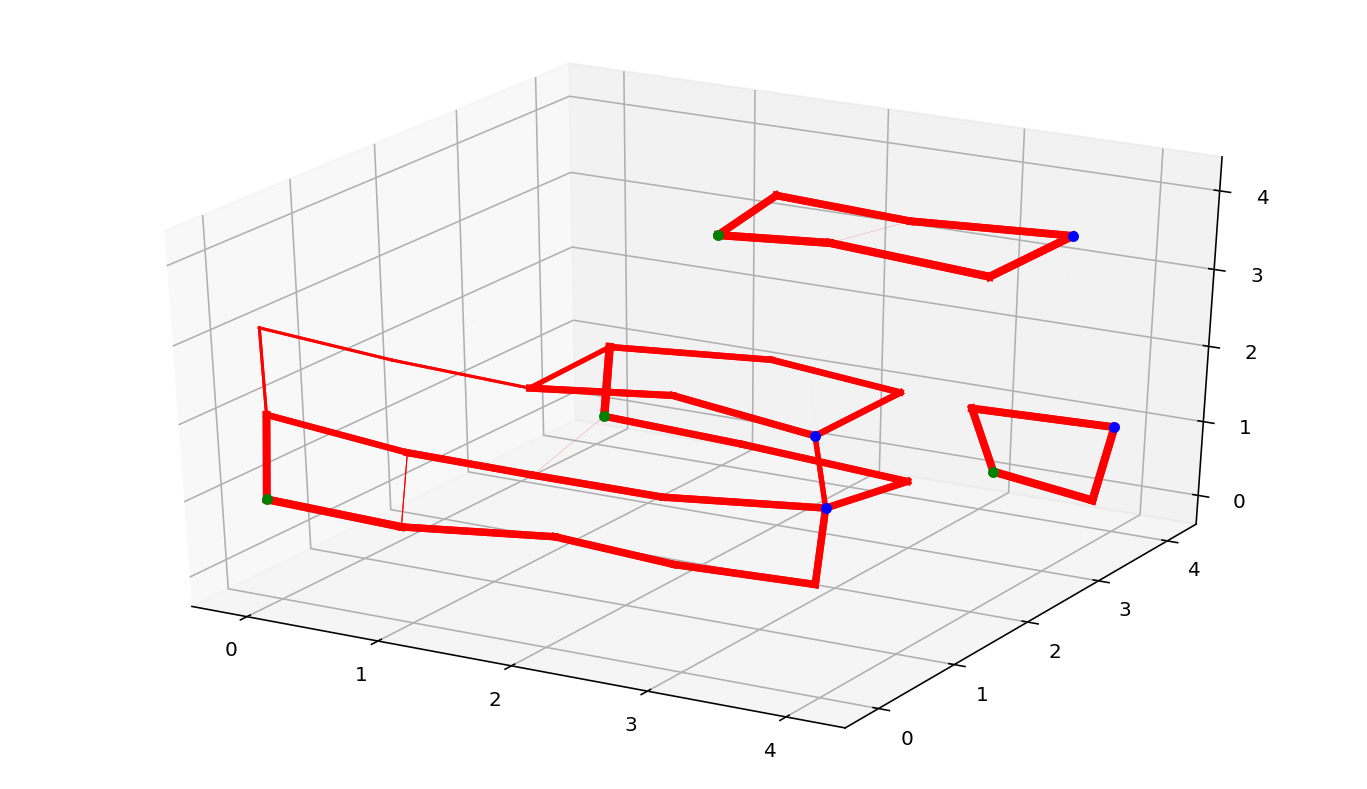

Le temps de la figure en dessous est t = 1300


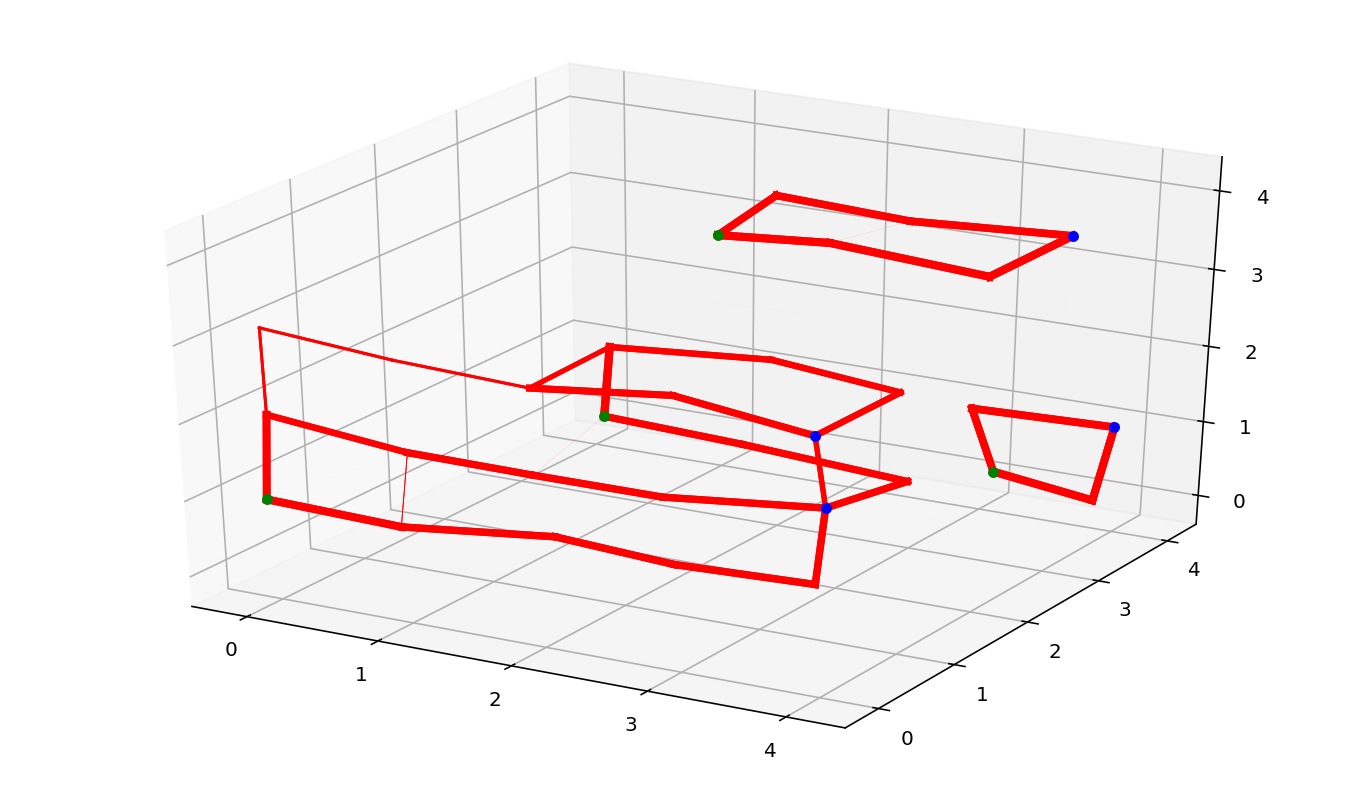

Le temps de la figure en dessous est t = 1400


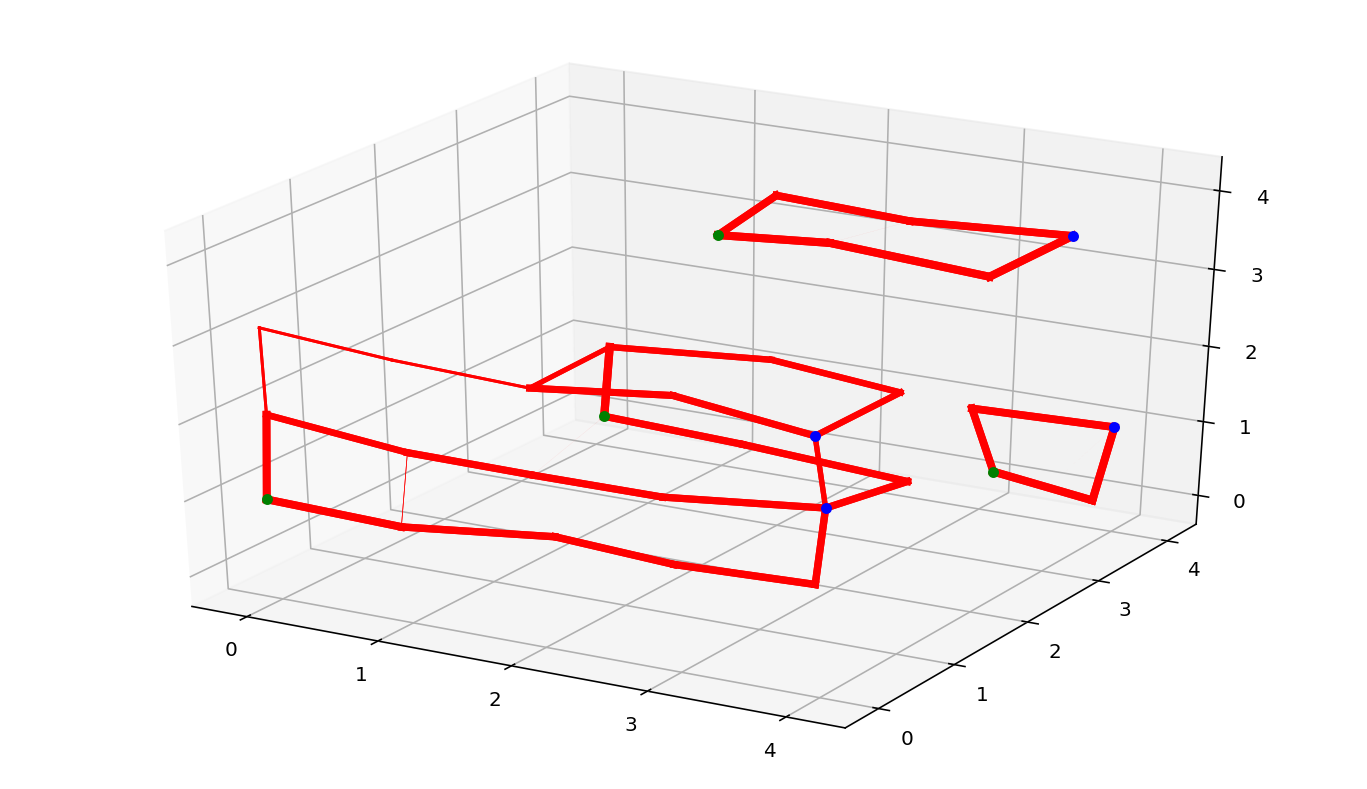

Le temps de la figure en dessous est t = 1500


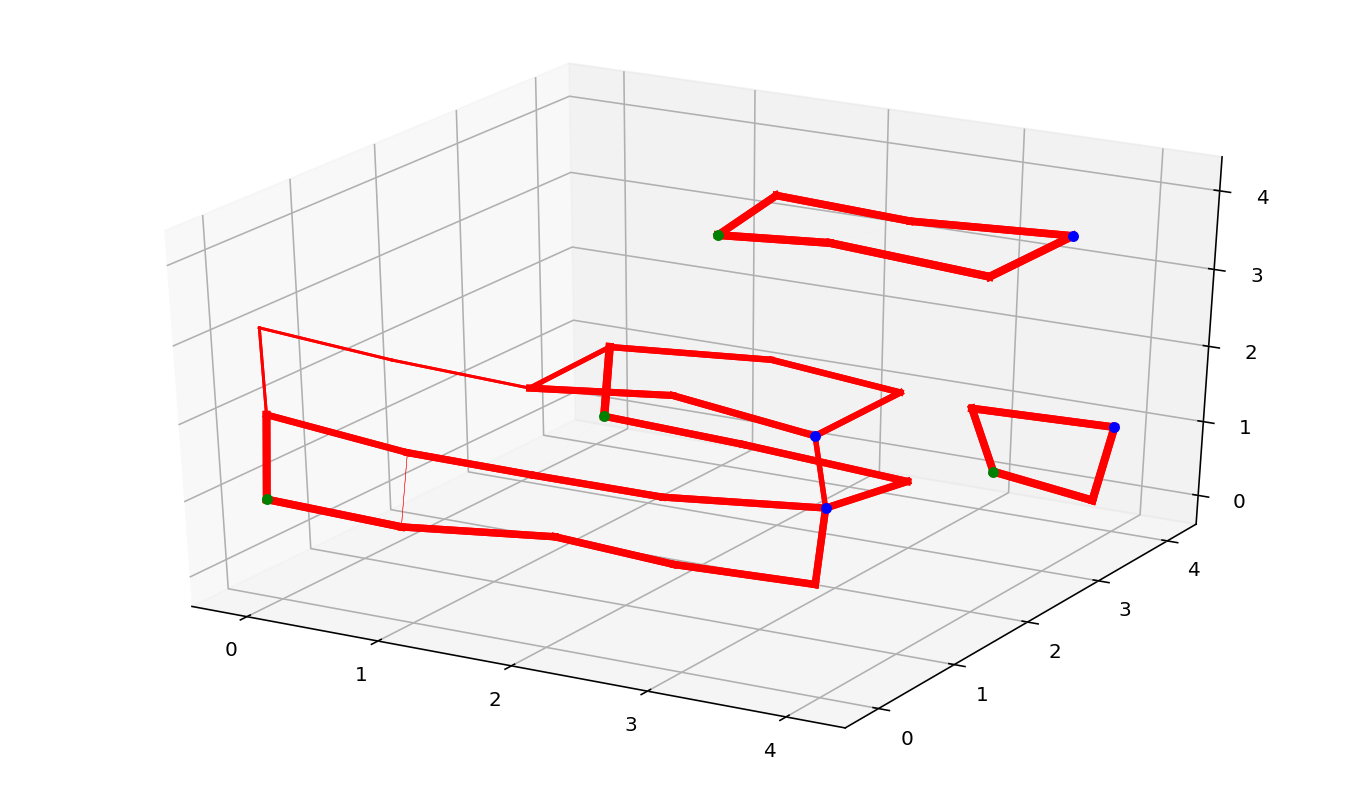

Le temps de la figure en dessous est t = 1600


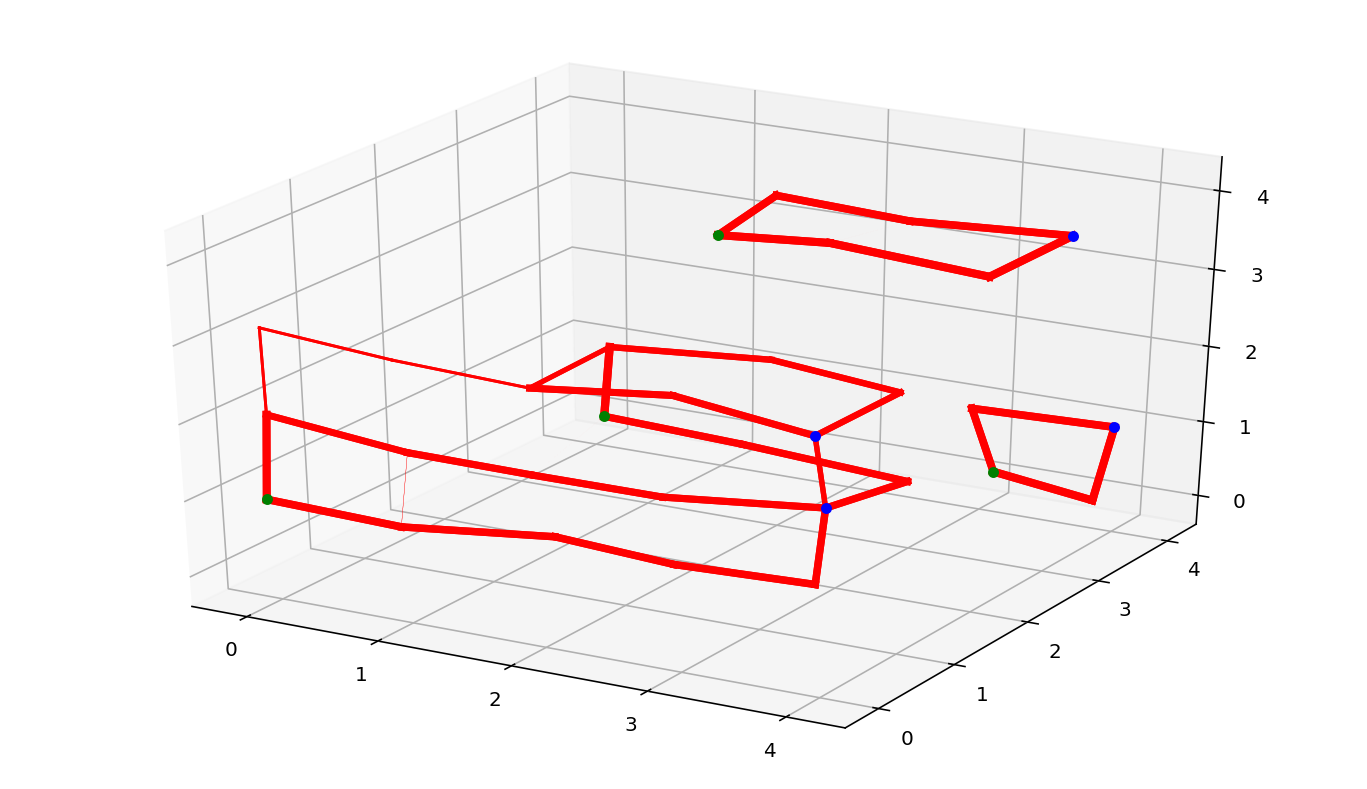

Le temps de la figure en dessous est t = 1700


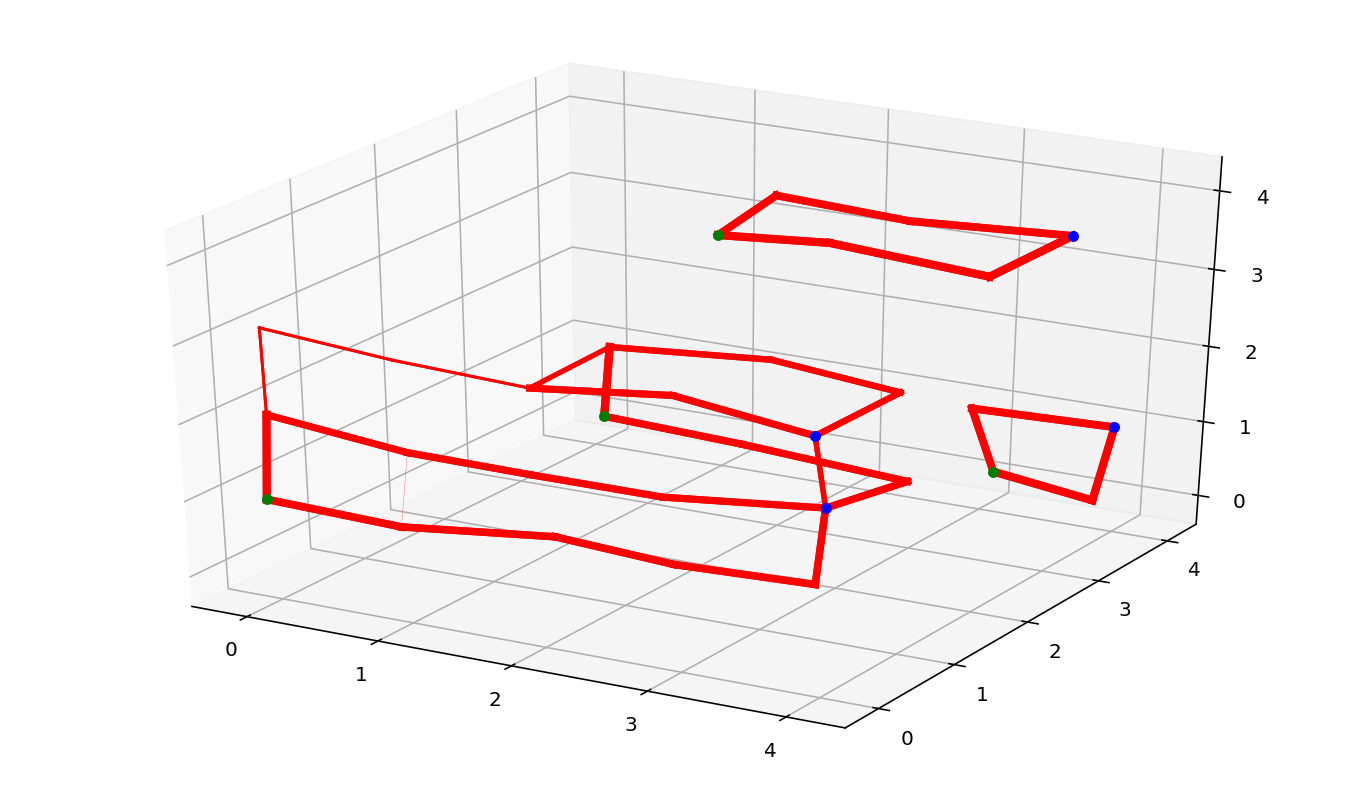

Le temps de la figure en dessous est t = 1800


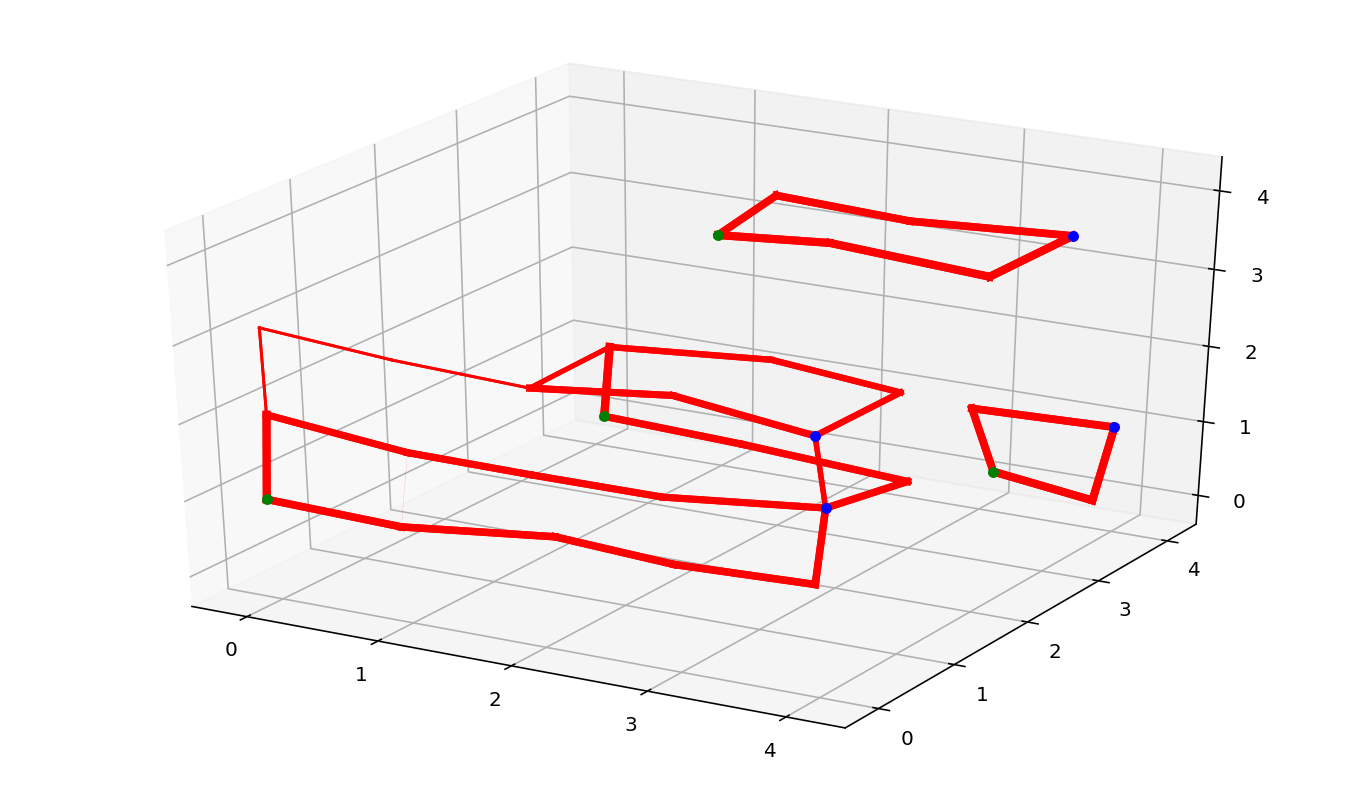

Le temps de la figure en dessous est t = 1900


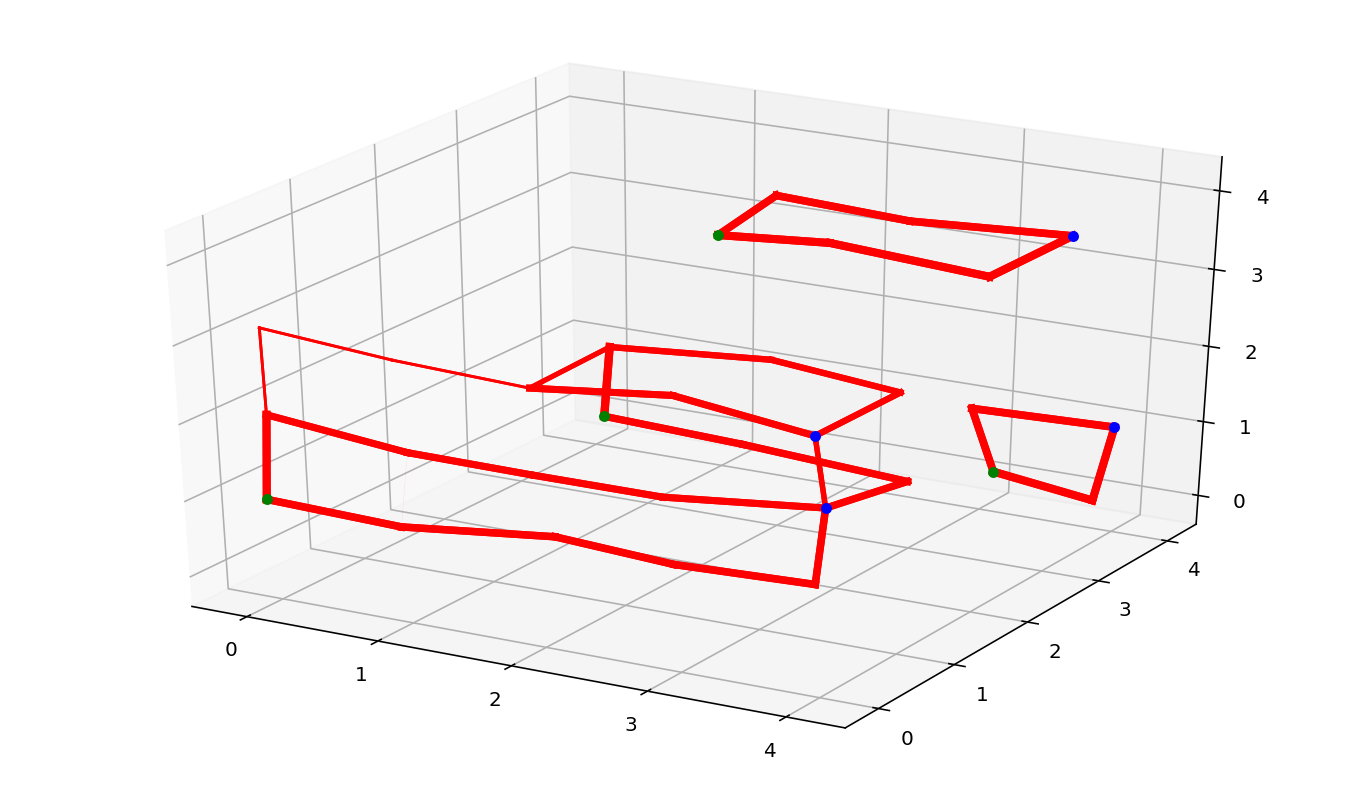

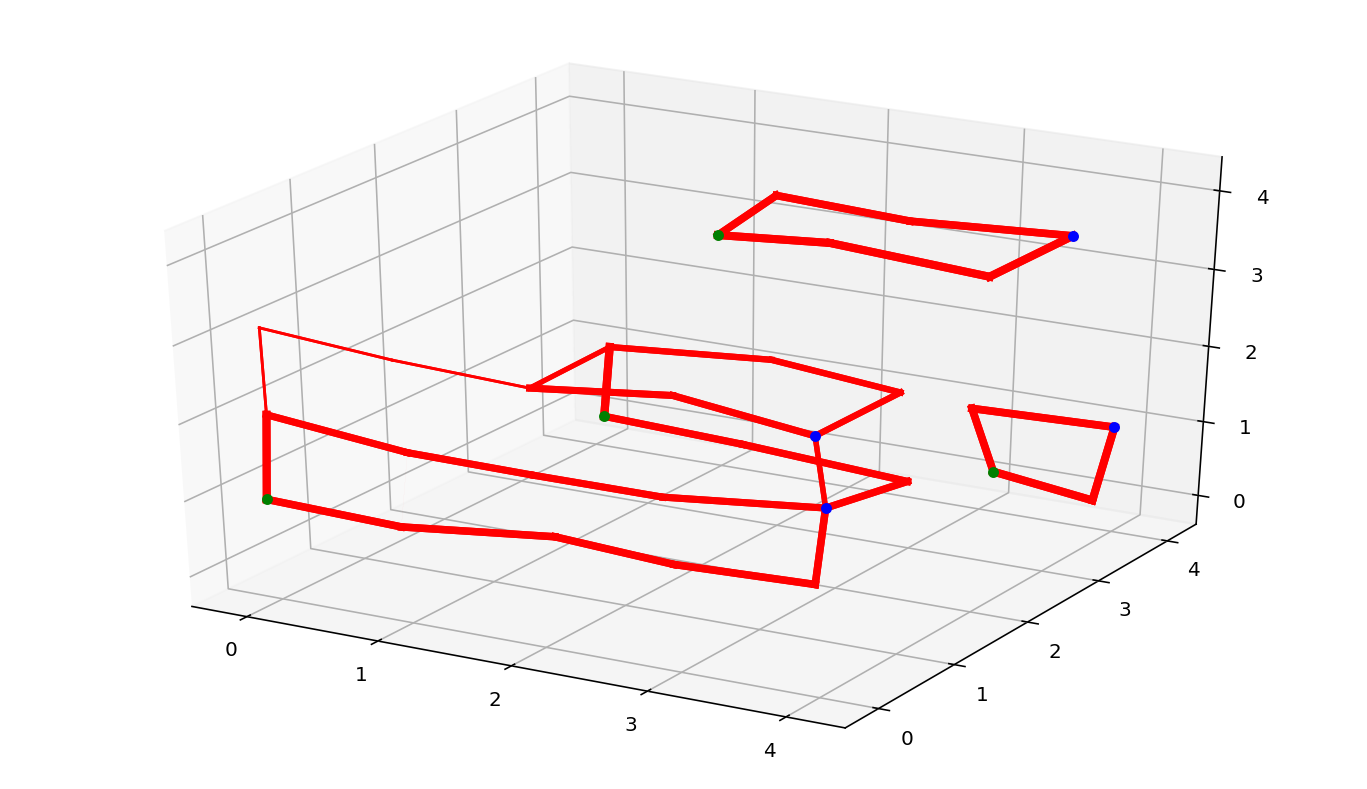

In [49]:
test_blob = blob(125,4,4,maille="3D")
for t in range(2000):
    test_blob.calcule_D(0.01,TAU=1)
    if t%100 == 0:
        print("Le temps de la figure en dessous est t =", t)
        test_blob.plot3D()
test_blob.plot3D()

In [7]:

print("2")

SyntaxError: 'break' outside loop (<ipython-input-7-56d24985713e>, line 4)